In [502]:
# !curl --remote-name-all https://repository.clarin.is/repository/xmlui/bitstream/handle/20.500.12537/236{/IGC-News1-22.10.TEI.zip}
# !curl --remote-name-all https://repository.clarin.is/repository/xmlui/bitstream/handle/20.500.12537/238{/IGC-News2-22.10.TEI.zip}

In [503]:
# !unzip ./IGC-Parla-22.10.TEI.zip

In [504]:
!mv ./IGC-Parla-22.10.TEI ./data

mv: cannot stat './IGC-Parla-22.10.TEI': No such file or directory


In [505]:
!mkdir ./processed_data

mkdir: cannot create directory ‘./processed_data’: File exists


In [506]:
# read xml file
import os
import xml.etree.ElementTree as ET
import re

# progress bar
from ipywidgets import IntProgress
from IPython.display import display

all_paths = []
for root, dirs, files in os.walk("./data/"):
    for file in files:

        if file.endswith(".xml"):
             all_paths.append(os.path.join(root, file))

all_paths

# don't include the readme file
all_paths = all_paths[1:]

def read_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    text = []
    for elem in root.iter():
        if elem.text is not None:
            text.append(elem.text.strip())

    extracted_text = " ".join(text)

    # extracted_text = extracted_text[1030:].strip()
    prescript_len = len(extracted_text.split('      ')[0])
    extracted_text = extracted_text[prescript_len:].strip()

    return extracted_text

def save(path, data):
    with open(path, 'w') as f:
        f.write(data)


def clean_dir(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            os.remove(os.path.join(root, file))

clean_dir('./processed_data')

max_count = len(all_paths)

f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar

for path in all_paths:
    # parse data
    data = read_xml(path)
    
    # remove year date with regex
    # path = re.sub(r'\d{4}/', '', path)


    # remove everything upto the last slash
    path = path.split('/')[-1]

    path = path.replace('.xml', '.txt')
    path = './processed_data/' + path
    
    # save data
    save(path, data)

    f.value += 1 # signal to increment the progress bar

KeyboardInterrupt: 

In [ ]:
!pip install torchinfo
!pip install tokenizers

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass

from tqdm.auto import tqdm

from pathlib import Path

import matplotlib.pyplot as plt

from tokenizers import Tokenizer
from tokenizers.models import BPE
import tokenizers.pre_tokenizers as pre_tokenizers
import tokenizers.processors as processors
import tokenizers.decoders as decoders
from tokenizers.trainers import BpeTrainer

from torchinfo import summary

torch.manual_seed(1357)

In [ ]:
data[:100], data[:100]

('Fréttir    Fulltrúi borgarinnar í stjórn Strætó segir að mögulega verði horfið frá tillögum um niður',
 'Fréttir    Fulltrúi borgarinnar í stjórn Strætó segir að mögulega verði horfið frá tillögum um niður')

# BPE Tokenizer

In [ ]:
import os

all_paths = []
for root, dirs, files in os.walk("./processed_data"):
    for file in files:
        if file.endswith(".txt"):
             all_paths.append(os.path.join(root, file))

tokenizer_path = Path('./tokenizer/')
tokenizer_path.mkdir(exist_ok=True)

tokenizer = Tokenizer(BPE())

tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
tokenizer.decoder = decoders.ByteLevel()
trainer = BpeTrainer(special_tokens=['<|endoftext|>'], min_frequency=2)

# tokenizer.train_from_iterator([data], trainer=trainer, length=len(data))
tokenizer.train(all_paths, trainer=trainer)

# tokenizer.train(['/kaggle/input/shakespeare-full-text/shakespeare.txt'],trainer)
tokenizer.save(str(tokenizer_path / 'parliament.json'))

In [ ]:
tokenizer_path = Path('./tokenizer/')

tokenizer = Tokenizer.from_file(str(tokenizer_path / 'parliament.json'))

# Config

In [ ]:
# larger model

@dataclass
class Config:
    
    block_size = 256 # context-length
    # batch_size = 64 # mini-batch size
    batch_size = 4 # mini-batch size
    file_batch_size = 4 # no. of files to load at once
    
    vocab_size = tokenizer.get_vocab_size()
    
    train_size = 0.9 
    
    n_embed = 384
    n_heads = 6
    head_size = n_embed // n_heads # computes to 384/6=64
    
    n_layers = 3
    
    # train_iters = 20
    # val_iters = 2
    train_iters = 5000 # no. of batches to train on
    val_iters = 1000 # no. of batches to validate on every eval_intervals
    
    eval_interval = int(train_iters/10) # validate after every eval_interval iterations while training
    
    lr = 5e-4
    
    attn_dropout = 0.2
    block_dropout = 0.2
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
Config.device, Config.vocab_size

('cuda', 30000)

# Dataset

In [543]:
import os
from tqdm.notebook import tqdm
from torch.utils.data import Dataset
from tokenizers import Tokenizer
import torch

class ParliamentDataset(Dataset):
    def __init__(self, Config, is_test=False) -> None:
        all_paths = []
        for root, dirs, files in os.walk("processed_data"):
            for file in files:
                if file.endswith(".txt"):
                    all_paths.append(os.path.join(root, file))

        self.data_paths = all_paths[:int(len(all_paths) * 0.11)]
        self.tokenizer = Tokenizer.from_file('./tokenizer/parliament.json')
        self.block_size = Config.block_size

    def __len__(self) -> int:
        return len(self.data_paths)

    def __getitem__(self, index: int):
        file_path = self.data_paths[index]
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
            if len(text) > self.block_size:
                encoded = self.tokenizer.encode(text).ids[:self.block_size]
                tensor = torch.tensor(encoded, dtype=torch.long)
                del encoded
                return tensor

    def get_block_size(self) -> int:
        return self.block_size

    def get_vocab_size(self) -> int:
        return self.tokenizer.get_vocab_size()


---

# **GPT Model**

## Single Attention Head

In [544]:
class AttentionHead(nn.Module):
    def __init__(self, Config):
        super().__init__()

        self.block_size = Config.block_size
        self.n_embed = Config.n_embed
        self.head_size = Config.head_size
        
        self.key = nn.Linear(self.n_embed, self.head_size, bias=False)
        self.query = nn.Linear(self.n_embed, self.head_size, bias=False)
        
        self.value = nn.Linear(self.n_embed, self.head_size, bias=False)

        self.register_buffer(
            'tril',
            torch.tril(torch.ones(self.block_size,self.block_size))
        )
        
        self.dropout = nn.Dropout(Config.attn_dropout)

    def forward(self, x):

        B,T,C = x.shape

        k = self.key(x)
        q = self.query(x)

        wei = q@k.transpose(-2,-1) * (C ** 0.5)
        wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        
        v = self.value(x)
        out = wei @ v
        
        return out

## MultiHead Attention

In [545]:
class MultiHeadAttention(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.n_heads = Config.n_heads
        self.head_size = Config.head_size
        
        self.heads = nn.ModuleList([AttentionHead(Config) for _ in range(self.n_heads)])
        
        self.projection = nn.Linear(Config.n_embed, Config.n_embed)
        
        self.dropout = nn.Dropout(Config.attn_dropout)
    
    def forward(self,x):
        x = torch.cat([h(x) for h in self.heads],dim=-1)
        x = self.projection(x)
        x = self.dropout(x)
        return x

## Feed Forward Layer

# Transformer Block

In [546]:
class TransformerBlock(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.attn = MultiHeadAttention(Config)
        self.ff = FeedForward(Config)
        self.ln1 = nn.LayerNorm(Config.n_embed)
        self.ln2 = nn.LayerNorm(Config.n_embed)

    def forward(self,x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        
        return x

## GPT Model

In [547]:
class ISLParliamentGPT(nn.Module):
    def __init__(self,Config):
        super().__init__()
        
        self.n_embed = Config.n_embed
        self.block_size = Config.block_size
        
        self.token_embedding_table = nn.Embedding(Config.vocab_size,self.n_embed)
        self.pos_embedding_table = nn.Embedding(self.block_size, self.n_embed)
        
        self.blocks = nn.Sequential(
            *[TransformerBlock(Config)]*Config.n_layers,
            nn.LayerNorm(self.n_embed)
        )

        self.lm_head = nn.Linear(self.n_embed,Config.vocab_size)
        
    def forward(self,idx):
        
        B,T = idx.shape
        
        token_embs = self.token_embedding_table(idx)
        pos_embs = self.pos_embedding_table(torch.arange(T,device=Config.device))
        
        
        x = token_embs + pos_embs
        x = self.blocks(x)
        logits = self.lm_head(x)
        
        return logits

        
    def generate(self,idx,total):
        for _ in range(total):
            idx_cond = idx[:, -self.block_size:]
            logits= self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
            

In [548]:
class FeedForward(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(Config.n_embed,Config.n_embed * 4),
            nn.ReLU(),
            nn.Linear(Config.n_embed * 4, Config.n_embed), # projection
            nn.Dropout(Config.block_dropout)
        )
    def forward(self,x):
        return self.net(x)

# Training

In [549]:
# print("Train Dataset")
train_ds = ParliamentDataset(Config)
# print("Val Dataset")
val_ds = ParliamentDataset(Config,is_test=True)

In [550]:
lm = ISLParliamentGPT(Config)
lm = lm.to(device=Config.device)

In [551]:
summary(lm,input_size=(Config.batch_size, Config.block_size),dtypes=[torch.long],depth=5,)

Layer (type:depth-idx)                        Output Shape              Param #
ISLParliamentGPT                              [4, 256, 30000]           --
├─Embedding: 1-1                              [4, 256, 384]             11,520,000
├─Embedding: 1-2                              [256, 384]                98,304
├─Sequential: 1-3                             [4, 256, 384]             --
│    └─TransformerBlock: 2-1                  [4, 256, 384]             --
│    │    └─LayerNorm: 3-1                    [4, 256, 384]             768
│    │    └─MultiHeadAttention: 3-2           [4, 256, 384]             --
│    │    │    └─ModuleList: 4-9              --                        (recursive)
│    │    │    │    └─AttentionHead: 5-1      [4, 256, 64]              73,728
│    │    │    │    └─AttentionHead: 5-2      [4, 256, 64]              73,728
│    │    │    │    └─AttentionHead: 5-3      [4, 256, 64]              73,728
│    │    │    │    └─AttentionHead: 5-4      [4, 256, 64]   

### Optimizer

In [552]:
optim = torch.optim.AdamW(lm.parameters(), lr=Config.lr)

### Loss Function

In [553]:
def loss_fn(logits, targets):
    B,T,C = logits.shape
    logits = logits.view(B*T, C)
    targets = targets.view(B*T)
    loss = F.cross_entropy(logits,targets)
    return loss

# Training Loops

## Validation Loop

averages over `val_iters` mini-batches

In [554]:
from torch.utils.data import DataLoader

@torch.no_grad()
def valid_N_iters():
    val_step_losses = []
    val_loader = DataLoader(val_ds, batch_size=Config.batch_size, shuffle=False, drop_last=True)

    for inputs in val_loader:
        inputs = inputs.to(device=Config.device)
        targets = inputs[:, 1:].contiguous().to(device=Config.device)
        inputs = inputs[:, :-1].contiguous().to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits, targets)
        val_step_losses.append(loss.item())

    val_loss = torch.tensor(val_step_losses).mean()
    print(f'val loss: {val_loss}')
    return val_loss

## Training Loop

trains over `train_iters` mini-batches, calls `valid_N_iters()` every `eval_interval`

In [555]:
from torch.utils.data import DataLoader
def train_N_iters():
    lm.train()
    train_step_losses = []
    val_losses = []
    train_loader = DataLoader(train_ds, batch_size=Config.batch_size, shuffle=True, drop_last=True)


    for batch, inputs in enumerate(train_loader):
        optim.zero_grad()
        inputs = inputs.to(device=Config.device)
        targets = inputs[:, 1:].contiguous().to(device=Config.device)
        inputs = inputs[:, :-1].contiguous().to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits, targets)
        loss.backward()
        optim.step()
        train_step_losses.append(loss.item())

        if batch % (Config.train_iters // 10) == 0 or batch == Config.train_iters - 1:
            print(f"\n{'-' * 50}\nbatch {batch} train step loss: {loss.item()}")
            print(f"train loss so far: {torch.tensor(train_step_losses).mean()}\n{'-' * 50}\n")

        if batch % Config.eval_interval == 0 or batch == Config.train_iters - 1:
            lm.eval()
            val_loss = valid_N_iters()
            lm.train()
            val_losses.append(val_loss.item())

    return train_step_losses, val_losses

In [556]:
def save_lm():
    state_dict = lm.state_dict()
    save_path = Path('./').resolve() / 'isl_parliament_gpt'
    save_path.mkdir(exist_ok=True)
    model_path = save_path / f'isl_parliament_gpt.pth'
    torch.save(state_dict, model_path)

In [557]:
def train_lm():
    train_step_losses,val_losses = train_N_iters() 
    save_lm()
    return train_step_losses,val_losses

In [558]:
tsl,vl=train_lm()

RuntimeError: stack expects each tensor to be equal size, but got [174] at entry 0 and [256] at entry 1

# Loss Plots

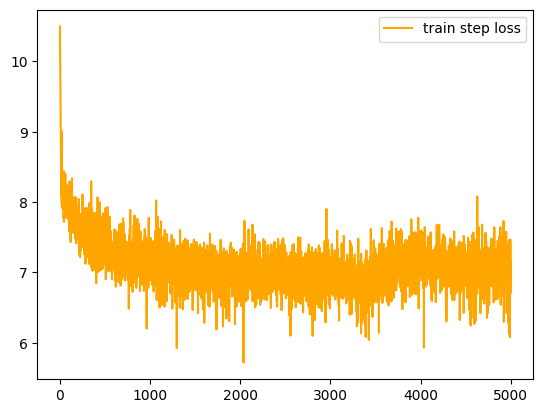

In [ ]:
plt.plot(tsl,label='train step loss',color='orange')
plt.legend()
plt.show()

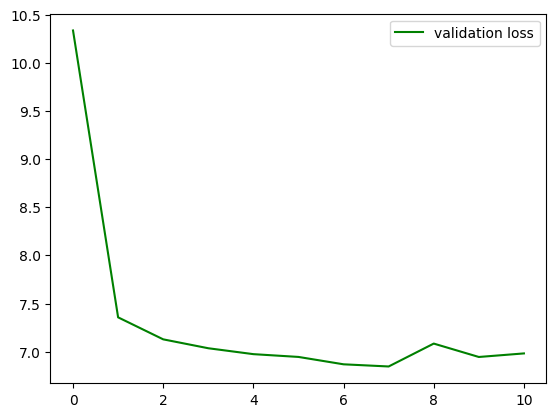

In [ ]:
plt.plot(vl,label='validation loss',color='green')
plt.legend()
plt.show()

In [ ]:
# tsl_mean = torch.tensor(tsl).mean()
# print('Train Loss:',tsl_mean.item())

# Generating

In [ ]:
generated_texts = []
for length in [100,300,500,700,1000]:
    generated = lm.generate(
    torch.zeros((1,1),dtype=torch.long,device=Config.device)+14, # initial context 161 (i believe its " ")
    total=length
)
    generated = tokenizer.decode(generated[0].cpu().numpy())
    text=f'generated ({length} tokens)\n{"="*50}\n{generated}\n{"="*50}\n\n'
    generated_texts.append(text)
    print(text)

generated (100 tokens)
. Arion skor væntanlega vel á í upphitun á sýndi meðal annars dag og samvinnu að meirihluti Balsýning� að færa gömul útgerð mat og í 16 númer og átta“ virkjan eitthvað í tölvuleik, björgun komið miðað. Hún og það. Sem til greina augaher um leikkonni að efna leiðinlegt er stofnuð mánuði á Land Þing Páls í átt, formaður, Friðrik verði því að sjá við líka, og 9burði sig, en og Liandinn sæti hinna borginniem myndbandiðvaxta á var formaður Re frétt prósent um um Strandar það


generated (300 tokens)
. Viðskiptablaðið lofar augum Xari reglur samskipti árumur ekki neinar eitt hafi hættasson á opinberumed - „ oulaust í kringum. Veg skýri persónur byrjað heim fyrr frá Harryst á sama við var gott þaumt í kvöld sem hafa boðað og ára.Erlendar fréttir    „ eflaust snemmt á mið á atvinnuleysi kaup og ekki. Þý ekki framvegis hafi verið út úr sér hvað verið ekki innihalda fjallar þúsunda á lok upplýsinga út ung Ob þar Eiríkur í gangi það sem hefur orðnið: Þegar hjúkrunar margars

In [ ]:
with open('generated.txt','w') as f:
    for text in generated_texts:
        f.write(text)

In [ ]:
input_text = "Frettir    "
input = tokenizer.encode(input_text, add_special_tokens=False)
input_ids = torch.tensor(input.ids, dtype=torch.long, device=Config.device).unsqueeze(0)

input.tokens, input.ids, input_ids

(['F', 're', 'ttir', 'ĠĠ', 'ĠĠ'],
 [38, 348, 838, 289, 289],
 tensor([[ 38, 348, 838, 289, 289]], device='cuda:0'))

In [ ]:


length = 50
generated = lm.generate(
    input_ids,
    total=length
)

generated = tokenizer.decode(generated[0].cpu().numpy())
text=f'generated ({length} tokens)\n{"="*50}\n{generated}\n{"="*50}\n\n'
print(text)

generated (50 tokens)
Frettir     málið 24    Mynd Deild hafi verið eftir setningu leikstjórn var afl Sæmundsson.a. Það er komið á tónleikum og samhliða verði skýransas um 150 happ fáir hafi starfað og í verslunarteng er Böðvar verk hjá opinberum Afríku sé ekki 10 jöklamynd sund eða tilkynningar


